In [1]:
%matplotlib inline
import os
import sys
from glob import glob
import pickle

import numpy as np
import pandas as pd
idx = pd.IndexSlice
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import copy

import geopandas as gpd

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import gpflow
import tensorflow as tf
import scipy

import tensorflow as tf
import numpy as np
import pickle
from gpflow.param import Param
from gpflow.model import Model
from gpflow.mean_functions import Zero
from gpflow import transforms, conditionals, kullback_leiblers
from gpflow.param import AutoFlow, DataHolder
from gpflow._settings import settings
from gpflow.minibatch import MinibatchData
from math import pi
import time



code_dir = '/cluster/home/kheuto01/code/zero-inflated-gp/'
sys.path.append(code_dir)

from onoffgpf import OnOffSVGP, OnOffLikelihood

/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("q

In [2]:
def mean_log_absolute_error(y_true, y_pred):
    
    min_val = abs(min(min(y_true), min(y_pred))) + 1

    return np.average(np.abs(np.log(y_pred.values+min_val) -
                             np.log(y_true.values+min_val)), axis=0)
def fixed_top_X(true_qtr_val,pred_qtr_val, X=10):
    
    top_X_predicted = pred_qtr_val.sort_values(ascending=False)[:X]
    top_X_true = true_qtr_val.sort_values(ascending=False)[:X]


    undisputed_top_predicted = top_X_predicted[top_X_predicted>top_X_predicted.min()]
    num_tied_spots = X - len(undisputed_top_predicted)
    undisputed_top_true = top_X_true[top_X_true > top_X_true.min()]
    num_true_ties = X - len(undisputed_top_true)


    tied_top_predicted = pred_qtr_val[pred_qtr_val==top_X_predicted.min()]
    tied_top_true = true_qtr_val[true_qtr_val==top_X_true.min()]

    error_in_top_true_ties = np.abs(tied_top_true-pred_qtr_val[tied_top_true.index]).sort_values(ascending=True)
    error_in_top_pred_ties = np.abs(true_qtr_val[tied_top_predicted.index]-tied_top_predicted).sort_values(ascending=True)
    top_true_tied_geoids = error_in_top_true_ties[:num_true_ties].index
    top_pred_tied_geoids = error_in_top_pred_ties[:num_tied_spots].index

    best_possible_top_true_geoids = pd.Index.union(undisputed_top_true.index, top_true_tied_geoids)
    best_possible_top_pred_geoids = pd.Index.union(undisputed_top_predicted.index, top_pred_tied_geoids)

    # True values of GEOIDS with highest actual deaths. If ties, finds tied locations that match preds best
    best_possible_true = true_qtr_val[best_possible_top_true_geoids]
    best_possible_pred = true_qtr_val[best_possible_top_pred_geoids]

    assert(len(best_possible_true)==X)
    assert(len(best_possible_pred)==X)

    best_possible_absolute = np.abs(best_possible_true.sum() - best_possible_pred.sum())
    best_possible_ratio = np.abs(best_possible_pred).sum()/np.abs(best_possible_true).sum()


    bootstrapped_tied_indices = np.random.choice(tied_top_predicted.index, (1000, num_tied_spots))
    bootstrapped_all_indices =  [pd.Index.union(undisputed_top_predicted.index,
                                                bootstrap_index) for bootstrap_index in bootstrapped_tied_indices]

    bootstrapped_absolute = np.mean([np.abs(top_X_true.sum() - true_qtr_val[indices].sum()) 
                                     for indices in bootstrapped_all_indices])
    bootstrapped_ratio = np.mean([np.abs(true_qtr_val[indices]).sum()/np.abs(top_X_true).sum()
                                  for indices in bootstrapped_all_indices])
    
    return best_possible_absolute, best_possible_ratio, bootstrapped_absolute, bootstrapped_ratio

In [3]:
data_dir = '/cluster/tufts/hugheslab/datasets/NSF_OD/'
result_dir = os.path.join(data_dir, 'results')
mass_shapefile = os.path.join(data_dir,'shapefiles','MA_2021')



new_tract_shapefile = os.path.join(data_dir,'shapefiles','new_trimmed_tract',
                                   'cb_2020_tract')

In [4]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    https://stackoverflow.com/a/4913653/1748679
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [5]:
mass_gdf = gpd.read_file(new_tract_shapefile)


svi_file = os.path.join(result_dir,'svi_qtr')
svi_gdf = gpd.read_file(svi_file)
svi_gdf = svi_gdf.rename(columns={'INTPTLAT':'lat', 'INTPTLON':'lon', 'GEOID':'grid_squar'})
# Make lat and lon floats
svi_gdf.loc[:, 'lat'] = svi_gdf.lat.astype(float)
svi_gdf.loc[:, 'lon'] = svi_gdf.lon.astype(float)
deaths_gdf = svi_gdf
missing_squares = [square for square in deaths_gdf['grid_squar'].unique() if square not in mass_gdf['GEOID'].unique()]
just_grid = deaths_gdf.loc[(deaths_gdf['year']==2000)&(deaths_gdf['quarter']==4), ['grid_squar','geometry', 'lat', 'lon']]

# Calculate each squares neighbors
neighbors = {}
for _, row in just_grid.iterrows():
    just_grid.loc[:,'haversine'] = just_grid.apply(lambda x: haversine(row['lon'], row['lat'],
                                                                         x['lon'], x['lat']),
                                                  axis=1)
    matching_neighbors = just_grid[just_grid['haversine']<8]['grid_squar'].values
    neighbors[row['grid_squar']]=matching_neighbors
    
tracts = deaths_gdf['grid_squar'].unique()
min_year = deaths_gdf.year.min()
max_year = deaths_gdf.year.max()

deaths_gdf = deaths_gdf.set_index(['grid_squar','year','quarter']).sort_index()
deaths_gdf.loc[idx[:,:,:],'self_t-1'] = deaths_gdf.loc[idx[:,:,:],'deaths'].shift(1, fill_value=0)

for tract in tracts:
     deaths_gdf.loc[idx[tract,:,:],'neighbor_t-1']= \
        deaths_gdf.loc[idx[neighbors[tract],:,:],'self_t-1'].groupby(level=['year', 'quarter']).mean().shift(1, fill_value=0).values

timestep = 0

for year in range(min_year, max_year+1):
    for quarter in range(1, 5):
        deaths_gdf.loc[idx[:,year, quarter], 'timestep'] = timestep
        timestep+=1
        
deaths_gdf_with_autoregressive = deaths_gdf.reset_index()

train_x_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar',  'timestep', 'deaths']]
train_x_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar', 'timestep', 'deaths']]

x_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2019][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
y_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2019][['grid_squar','timestep', 'deaths']]
x_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2020][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
y_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2020][['grid_squar', 'timestep', 'deaths']]

x_just_2019q1 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
y_just_2019q1 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','timestep', 'deaths']]


In [6]:
with open('/cluster/tufts/hugheslab/kheuto01/opioid/logs/qtr/ind100_iter3000/model.pkl','rb') as f:
    m = pickle.load(f)

In [13]:
fold='train'
norm_mean, norm_var, _, _, _, _, _, _, _ =  m.predict_onoffgp(m.X.value)
norm_mean=norm_mean.squeeze()
norm_var = m.likelihood.variance.value[0]
norm_cdf_upper_bound = m.Y.value.squeeze()+0.5
norm_cdf_lower_bound = m.Y.value.squeeze()-0.5

norm_likelihood_upper =  0.5 * (1.0 + scipy.special.erf((norm_cdf_upper_bound-norm_mean) / (np.sqrt(norm_var)*np.sqrt(2.0))))
norm_likelihood_lower =  0.5 * (1.0 + scipy.special.erf((norm_cdf_lower_bound-norm_mean) / (np.sqrt(norm_var)*np.sqrt(2.0))))
norm_likelihood_lower[norm_cdf_lower_bound==-0.5] = 0
print(f'Likelihood {fold}: {np.mean(norm_likelihood_upper-norm_likelihood_lower)}')
print(f'Cont. likelihood {fold}: {np.mean(scipy.stats.norm(norm_mean,m.likelihood.variance.value[0]).pdf(m.Y.value.squeeze()))}')
print(f'MAE {fold} {mean_absolute_error(m.Y.value, norm_mean)}')

Likelihood train: 0.7588773108405549
Cont. likelihood train: 1.698666846467926
MAE train 0.22002052261635718


In [9]:
bprs = []
for year in range(2000, 2018):
    for quarter in range(1,5):
        xq = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==year) & (deaths_gdf_with_autoregressive['quarter']==quarter)][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
        yq = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==year) & (deaths_gdf_with_autoregressive['quarter']==quarter)][['grid_squar','timestep', 'deaths']]
        norm_mean, norm_var, _, _, _, _, _, _, _ =  m.predict_onoffgp(xq.iloc[:,1:])

        norm_cdf_upper_bound = yq['deaths'].values+0.5
        norm_cdf_lower_bound = yq['deaths'].values-0.5
        norm_likelihood_upper =  0.5 * (1.0 + scipy.special.erf((norm_cdf_upper_bound-norm_mean) / (np.sqrt(norm_var)*np.sqrt(2.0))))
        norm_likelihood_lower =  0.5 * (1.0 + scipy.special.erf((norm_cdf_lower_bound-norm_mean) / (np.sqrt(norm_var)*np.sqrt(2.0))))
        norm_likelihood_lower[norm_cdf_lower_bound==-0.5] = 0

        bpr = fixed_top_X(yq.set_index(['grid_squar'])['deaths'], pd.Series(norm_mean.squeeze(), index=x_just_2019q1.grid_squar), X=100)[-1]
        bprs.append(bpr)
print(f'Train bpr-100: {np.mean(bprs)}')

Train bpr-100: 0.21870103641309738


In [169]:
bprs

[0.15909090909090912,
 0.14117647058823524,
 0.16666666666666663,
 0.11494252873563221,
 0.12380952380952383,
 0.17142857142857137,
 0.14141414141414144,
 0.17431192660550462,
 0.12380952380952383,
 0.14814814814814814,
 0.19090909090909092,
 0.09433962264150944,
 0.17857142857142852,
 0.21238938053097337,
 0.1538461538461538,
 0.24545454545454554,
 0.17592592592592599,
 0.12380952380952383,
 0.10891089108910895,
 0.17592592592592599,
 0.21238938053097337,
 0.14678899082568808,
 0.21621621621621626,
 0.25438596491228077,
 0.17431192660550462,
 0.2173913043478261,
 0.16666666666666663,
 0.18518518518518517,
 0.25438596491228077,
 0.1891891891891892,
 0.1944444444444445,
 0.13513513513513511,
 0.1875,
 0.15517241379310348,
 0.24299065420560736,
 0.20909090909090902,
 0.1652173913043478,
 0.20560747663551393,
 0.13513513513513511,
 0.20353982300884962,
 0.16190476190476188,
 0.14563106796116504,
 0.13513513513513511,
 0.16504854368932037,
 0.1826086956521739,
 0.11320754716981131,
 0.2307

In [14]:
fold='test'
norm_mean, norm_var, _, _, _, _, _, _, _ =  m.predict_onoffgp(x_just_2019.iloc[:,1:])
norm_mean=norm_mean.squeeze()
norm_var = m.likelihood.variance.value[0]
norm_cdf_upper_bound = y_just_2019['deaths'].values.squeeze()+0.5
norm_cdf_lower_bound = y_just_2019['deaths'].values.squeeze()-0.5

norm_likelihood_upper =  0.5 * (1.0 + scipy.special.erf((norm_cdf_upper_bound-norm_mean) / (np.sqrt(norm_var)*np.sqrt(2.0))))
norm_likelihood_lower =  0.5 * (1.0 + scipy.special.erf((norm_cdf_lower_bound-norm_mean) / (np.sqrt(norm_var)*np.sqrt(2.0))))
norm_likelihood_lower[norm_cdf_lower_bound==-0.5] = 0

print(f'Likelihood {fold}: {np.mean(norm_likelihood_upper-norm_likelihood_lower)}')
print(f"MAE {fold} {mean_absolute_error(y_just_2019['deaths'].values, norm_mean)}")
print(f'Cont. likelihood {fold}: {np.mean(scipy.stats.norm(norm_mean,m.likelihood.variance.value[0]).pdf(y_just_2019["deaths"].values.squeeze()))}')

Likelihood test: 0.6330416986886735
MAE test 0.38921212018495843
Cont. likelihood test: 0.7843140697143706


In [15]:
bprs=[]
for quarter in range(1,5):
    xq = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==quarter)][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
    yq = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==quarter)][['grid_squar','timestep', 'deaths']]

    
    fold='test'
    norm_mean, norm_var, _, _, _, _, _, _, _ =  m.predict_onoffgp(xq.iloc[:,1:])
    norm_mean=norm_mean.squeeze()
    norm_var = norm_var.squeeze()
    norm_cdf_upper_bound = yq['deaths'].values.squeeze()+0.5
    norm_cdf_lower_bound = yq['deaths'].values.squeeze()-0.5

    norm_likelihood_upper =  0.5 * (1.0 + scipy.special.erf((norm_cdf_upper_bound-norm_mean) / (np.sqrt(norm_var)*np.sqrt(2.0))))
    norm_likelihood_lower =  0.5 * (1.0 + scipy.special.erf((norm_cdf_lower_bound-norm_mean) / (np.sqrt(norm_var)*np.sqrt(2.0))))
    norm_likelihood_lower[norm_cdf_lower_bound==-0.5] = 0

    
    bpr = fixed_top_X(yq.set_index(['grid_squar'])['deaths'], pd.Series(norm_mean.squeeze(), index=x_just_2019q1.grid_squar), X=100)[-1]
    bprs.append(bpr)
    
print(f'Test bpr-100: {np.mean(bprs)}')

Test bpr-100: 0.3448142414860681


In [14]:
norm_mean.shape

(1620,)

In [159]:
pd.__version__

'1.1.5'

In [89]:
import scipy

In [21]:
gpflow

<module 'gpflow' from '/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/gpflow/__init__.py'>

In [22]:
gpflow.__version__

'0.4.0'

In [61]:
def normcdf(x, mean, std_dev):
    return 0.5 * (1.0 + tf.math.erf((x-mean) / (std_dev*np.sqrt(2.0)))) 

In [40]:
.shape

(123120, 8)

In [126]:
x_just_2019

,grid_squar,lat,lon,timestep,theme_1_pc,theme_2_pc,theme_3_pc,theme_4_pc,svi_pctile,neighbor_t-1,self_t-1
76,25001010100,42.059829,-70.200407,76.0,0.5846,0.3659,0.2235,0.8203,0.5854,0.000000,0.0
77,25001010100,42.059829,-70.200407,77.0,0.5846,0.3659,0.2235,0.8203,0.5854,0.000000,0.0
78,25001010100,42.059829,-70.200407,78.0,0.5846,0.3659,0.2235,0.8203,0.5854,0.000000,0.0
79,25001010100,42.059829,-70.200407,79.0,0.5846,0.3659,0.2235,0.8203,0.5854,0.000000,1.0
164,25001010206,41.922636,-70.015368,76.0,0.6196,0.5629,0.0957,0.5658,0.5244,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
142463,25027761401,42.489753,-71.579677,79.0,0.2906,0.4124,0.3944,0.1598,0.2237,0.333333,0.0
142548,25027761402,42.531342,-71.592751,76.0,0.2906,0.4124,0.3944,0.1598,0.2237,0.250000,0.0
142549,25027761402,42.531342,-71.592751,77.0,0.2906,0.4124,0.3944,0.1598,0.2237,0.125000,0.0
142550,25027761402,42.531342,-71.592751,78.0,0.2906,0.4124,0.3944,0.1598,0.2237,0.500000,0.0


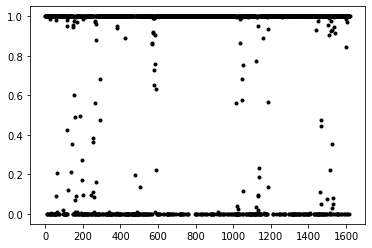

In [16]:
plt.plot((norm_likelihood_upper-norm_likelihood_lower),'k.')

In [34]:
probs =(norm_likelihood_upper-norm_likelihood_lower).mean(-1)

In [35]:
probs[np.logical_and(probs<0.8,  probs>0.7)]

array([0.77407407, 0.77407407, 0.77407407, 0.76588114, 0.77407023,
       0.77407407, 0.77407407, 0.77407407, 0.77407407, 0.77394097,
       0.77407407, 0.72405001, 0.77407407, 0.77407407, 0.77407407,
       0.77407324, 0.77407128, 0.77407407, 0.7345    , 0.77407405,
       0.77407228, 0.77335715, 0.77407407, 0.77407343, 0.77407407,
       0.77407407, 0.77407407, 0.7740734 , 0.77404807, 0.77241323,
       0.77407405, 0.77405194, 0.77406612, 0.77407407, 0.77407407,
       0.77406876, 0.7739142 , 0.77405449, 0.71737941, 0.77367372,
       0.76723426, 0.77271534, 0.77379845, 0.77407407, 0.77407407,
       0.77407407, 0.77407407, 0.77407407, 0.77407407, 0.77407407,
       0.77406054, 0.77407095, 0.77407407, 0.7210592 , 0.70401047,
       0.77407407, 0.7740648 , 0.77407402, 0.77407407, 0.77407407,
       0.77407407, 0.77407407, 0.77407407, 0.77407407, 0.77407407,
       0.77407407, 0.77289937, 0.77407317, 0.77407407, 0.77407407,
       0.77407407, 0.77158411, 0.77407198, 0.77407391, 0.77406

In [37]:
yq[np.isclose(probs,0.77407407)]

,grid_squar,timestep,deaths
687,25001010600,71.0,1.0
2095,25001012101,71.0,1.0
2359,25001012502,71.0,1.0
3503,25001013700,71.0,1.0
3679,25001013900,71.0,1.0
...,...,...,...
141223,25027756102,71.0,2.0
141487,25027757300,71.0,1.0
141839,25027758103,71.0,2.0
142103,25027760100,71.0,1.0


In [39]:
norm_var[np.isclose(probs,0.77407407)]

array([[1.74308219e-03],
       [1.89407733e-03],
       [1.69807279e-03],
       [1.27748855e-03],
       [1.30381824e-03],
       [8.12991333e-04],
       [8.12017906e-04],
       [1.11095937e-03],
       [1.98406499e-03],
       [8.93517547e-04],
       [1.65125759e-03],
       [9.28317698e-04],
       [1.26804105e-03],
       [1.42531684e-03],
       [5.97028064e-04],
       [1.61463993e-03],
       [1.84209954e-03],
       [1.62485177e-03],
       [1.65915955e-03],
       [1.48711310e-03],
       [1.56347935e-03],
       [7.05549518e-04],
       [7.25018962e-04],
       [5.49023481e-04],
       [4.78444204e-04],
       [9.37222292e-04],
       [1.00597853e-03],
       [9.84560611e-04],
       [1.10542300e-03],
       [6.19372260e-04],
       [4.21843781e-04],
       [2.79715359e-03],
       [5.35187425e-04],
       [1.22609378e-03],
       [5.03278596e-04],
       [3.54489942e-04],
       [4.86720303e-04],
       [4.23164144e-04],
       [6.27133335e-04],
       [6.72866987e-04],


In [46]:
(norm_cdf_upper_bound-norm_mean)[np.isclose(probs,0.77407407)]

array([[0.29244528, 0.29244528, 0.29244528, ..., 0.29244528, 0.29244528,
        0.29244528],
       [0.29434796, 0.29434796, 0.29434796, ..., 0.29434796, 0.29434796,
        0.29434796],
       [0.24313686, 0.24313686, 0.24313686, ..., 0.24313686, 0.24313686,
        0.24313686],
       ...,
       [0.33157419, 0.33157419, 0.33157419, ..., 0.33157419, 0.33157419,
        0.33157419],
       [0.30526006, 0.30526006, 0.30526006, ..., 0.30526006, 0.30526006,
        0.30526006],
       [0.29743427, 0.29743427, 0.29743427, ..., 0.29743427, 0.29743427,
        0.29743427]])

In [49]:
norm_likelihood_lower.shape

(1620, 1620)

In [48]:
norm_mean

array([[0.22273666],
       [0.18940469],
       [0.16785569],
       ...,
       [0.2121951 ],
       [0.13614741],
       [0.14060298]])

In [56]:
scipy.special.erf((norm_cdf_upper_bound-norm_mean.squeeze()) / (np.sqrt(norm_var.squeeze())*np.sqrt(2.0))).shape

(1620,)

In [55]:
(norm_cdf_upper_bound-norm_mean.squeeze()).shape

(1620,)

In [52]:
norm_cdf_upper_bound.shape

(1620,)

In [53]:
norm_mean.shape

(1620, 1)

In [10]:
norm_cdf_upper_bound.shape

(123120, 1)

In [13]:
(norm_cdf_upper_bound-norm_mean).shape

(123120,)

In [18]:
norm_likelihood_upper.shape

(123120,)

In [22]:
norm_likelihood_upper.shape

(6480,)

In [25]:
(y_just_2019['deaths'].values.squeeze()>0).mean()

0.2359567901234568

In [17]:
norm_likelihood_upper.shape

(1620,)

In [15]:
m.likelihood.variance.value[0]

0.1419540360946301

In [11]:
m.Y.value.squeeze()

array([0., 0., 0., ..., 0., 1., 0.])